<h1> Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Required imports for neural network
import torch.nn as nn
import torch
from torch.autograd import Variable
import random

<h1> Data Loading and Generation

This Sine function generator is based on the repostory: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

In [2]:
class SineWaveTask_multi:
    def __init__(self,dimensionss=20):
        self.dimensions = dimensions
        self.a = []
        self.b = []
        for dim in range(self.dimensions):
          self.a.append(np.random.uniform(0.1, 5.0))
          self.b.append(np.random.uniform(0, 2*np.pi))
        self.train_x = None
        
    def f(self, x,a,b):
        return a * np.sin(x + b)
        
    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x

        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)

        y = self.f(x,self.a[0],self.b[0])[:,None]

        for dim in range(self.dimensions-1):
          y = np.concatenate((y,self.f(x,self.a[dim+1],self.b[dim+1])[:,None]),axis=-1)

        return torch.Tensor(x[:,None]), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x,self.a[0],self.b[0])[:,None]

        for dim in range(self.dimensions-1):
          y = np.concatenate((y,self.f(x,self.a[dim+1],self.b[dim+1])[:,None]),axis=-1)

        return torch.Tensor(x[:,None]), torch.Tensor(y)
    

TRAIN_SIZE = 20000
TEST_SIZE = 1000
SINE_TRAIN = [SineWaveTask_multi() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask_multi() for _ in range(TEST_SIZE)]

In [3]:
x, y_true = SINE_TRAIN[0].training_set()

In [4]:
y_true.shape

torch.Size([10, 20])

<h1> Neural Network Model

In [5]:
# Define network
class Neural_Network_multi(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=20):
        super(Neural_Network_multi, self).__init__()
        # network layers
        self.hidden1 = nn.Linear(input_size,hidden_size)
        self.hidden2 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size,output_size)

        #Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        y = x
        return y


<h1> Helper functions

In [6]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network_multi()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def get_samples_in_good_format(wave):
  #This function is used to sample data from a wave
  x, y_true = wave.training_set()
  # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
  # Note that we convert everything torch tensors
  x = torch.tensor(x)
  y_true = torch.tensor(y_true)
  return x,y_true

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, wave, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, wave)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,wave,store_train_loss_meta):
    loss = evaluation(new_model, wave)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, item = True):
    # Get data
    x, label = get_samples_in_good_format(wave)
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,label).item()
    else:
      loss = criterion(prediction,label)
    return loss

def training(model, wave, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

<h1> Reptile

In [9]:
#Define important variables
epochs = 10000 * 25 # match number of tasks as maml #int(1e5) # number of epochs 
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=1000 # how many epochs should we wait to print the loss
lr_k=0.01 # Internal learning rate
k=5 # Number of internal updates for each task

# Initializations
initialization_to_store_meta_losses()
model = Neural_Network_multi()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [10]:
# Training loop
for epoch in range(epochs):
        
    # Sample a sine wave (Task from training data)
    wave = random.sample(SINE_TRAIN, 1)

    # Update model predefined number of times based on k
    new_model = training(model, wave[0], lr_k, k)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,wave[0],store_train_loss_meta)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the wave from the test data
    wave = random.sample(SINE_TEST, 1)
    test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

<ipython-input-6-7e1e6714c74e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
<ipython-input-6-7e1e6714c74e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)
<ipython-input-6-7e1e6714c74e>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parameter.grad = torch.tensor(torch.zeros_like(parameter))


Epochh : 0, Average Train Meta Loss : 3.3502609729766846, Average Test Meta Loss : 4.1124114990234375
Epochh : 1000, Average Train Meta Loss : 3.900453130324761, Average Test Meta Loss : 3.917694209338902
Epochh : 2000, Average Train Meta Loss : 3.5197313318307373, Average Test Meta Loss : 3.544909173402114
Epochh : 3000, Average Train Meta Loss : 3.317859416661839, Average Test Meta Loss : 3.346317815049733
Epochh : 4000, Average Train Meta Loss : 3.196215017233393, Average Test Meta Loss : 3.2317256881755103
Epochh : 5000, Average Train Meta Loss : 3.1138881211327543, Average Test Meta Loss : 3.1610038158917897
Epochh : 6000, Average Train Meta Loss : 3.0586615891044207, Average Test Meta Loss : 3.1068280675951154
Epochh : 7000, Average Train Meta Loss : 3.0146391687436096, Average Test Meta Loss : 3.0678567603952014
Epochh : 8000, Average Train Meta Loss : 2.9803396476356556, Average Test Meta Loss : 3.032469659168383
Epochh : 9000, Average Train Meta Loss : 2.9430513087278896, Aver

Epochh : 78000, Average Train Meta Loss : 1.1612565595430206, Average Test Meta Loss : 1.1859315880728967
Epochh : 79000, Average Train Meta Loss : 1.1494810408301295, Average Test Meta Loss : 1.1738448640207797
Epochh : 80000, Average Train Meta Loss : 1.1377161970537026, Average Test Meta Loss : 1.1624335212406949
Epochh : 81000, Average Train Meta Loss : 1.126434935900806, Average Test Meta Loss : 1.150803844994755
Epochh : 82000, Average Train Meta Loss : 1.1158765873461762, Average Test Meta Loss : 1.1393402296613702
Epochh : 83000, Average Train Meta Loss : 1.1048359024220988, Average Test Meta Loss : 1.1289231663705825
Epochh : 84000, Average Train Meta Loss : 1.0943356457961448, Average Test Meta Loss : 1.118679189820455
Epochh : 85000, Average Train Meta Loss : 1.0841953145088181, Average Test Meta Loss : 1.1091557129692797
Epochh : 86000, Average Train Meta Loss : 1.074246551765471, Average Test Meta Loss : 1.0993100122039483
Epochh : 87000, Average Train Meta Loss : 1.064297

Epochh : 155000, Average Train Meta Loss : 0.6933158941355757, Average Test Meta Loss : 0.7233345425578039
Epochh : 156000, Average Train Meta Loss : 0.6900944579846569, Average Test Meta Loss : 0.7204490225248525
Epochh : 157000, Average Train Meta Loss : 0.6870292720849563, Average Test Meta Loss : 0.7187577228445605
Epochh : 158000, Average Train Meta Loss : 0.6840462100514477, Average Test Meta Loss : 0.7161084058042655
Epochh : 159000, Average Train Meta Loss : 0.6812153967232056, Average Test Meta Loss : 0.7131568722361857
Epochh : 160000, Average Train Meta Loss : 0.6781240234597915, Average Test Meta Loss : 0.7102965882752977
Epochh : 161000, Average Train Meta Loss : 0.6752901526375065, Average Test Meta Loss : 0.707487425819898
Epochh : 162000, Average Train Meta Loss : 0.6725525716137125, Average Test Meta Loss : 0.704573202068017
Epochh : 163000, Average Train Meta Loss : 0.669593033643375, Average Test Meta Loss : 0.7015202575463755
Epochh : 164000, Average Train Meta Loss

Epochh : 232000, Average Train Meta Loss : 0.530843334797914, Average Test Meta Loss : 0.5674544837962394
Epochh : 233000, Average Train Meta Loss : 0.529502118481463, Average Test Meta Loss : 0.5659693563145021
Epochh : 234000, Average Train Meta Loss : 0.5280866275515049, Average Test Meta Loss : 0.5650265098800601
Epochh : 235000, Average Train Meta Loss : 0.5268543659292445, Average Test Meta Loss : 0.563521344684749
Epochh : 236000, Average Train Meta Loss : 0.5254298713764145, Average Test Meta Loss : 0.5620843543984931
Epochh : 237000, Average Train Meta Loss : 0.5244311994751221, Average Test Meta Loss : 0.5607280790445995
Epochh : 238000, Average Train Meta Loss : 0.5230630823905367, Average Test Meta Loss : 0.55919725667398
Epochh : 239000, Average Train Meta Loss : 0.5217565922859876, Average Test Meta Loss : 0.5580359662396513
Epochh : 240000, Average Train Meta Loss : 0.5205220884944202, Average Test Meta Loss : 0.556590267609518
Epochh : 241000, Average Train Meta Loss : 

<h1> Few Shot learning with new meta-model

The model performs good few shot learning

<ipython-input-6-7e1e6714c74e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
<ipython-input-6-7e1e6714c74e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)


Text(0.5, 0, 'k shots')

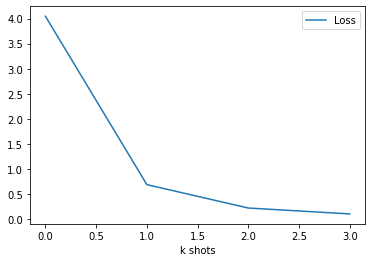

In [11]:
wave = SineWaveTask_multi(); 
k_shot_updates = 4
initialization_to_store_meta_losses()
for shots in range(k_shot_updates):
    new_model = training(model, wave, lr_k, shots)
    train_set_evaluation(new_model,wave,store_train_loss_meta) 

plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')

<ipython-input-6-7e1e6714c74e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
<ipython-input-6-7e1e6714c74e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)


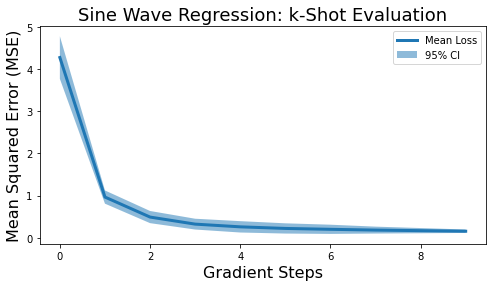

In [16]:
all_losses = []
num_eval = 100 
num_k_shots = 10

for test_eval in range(num_eval): 

    wave = SineWaveTask_multi(); 
    k_shot_updates = num_k_shots
    initialization_to_store_meta_losses()
    for shots in range(k_shot_updates):
        new_model = training(model, wave, lr_k, shots)
        train_set_evaluation(new_model,wave,store_train_loss_meta) 
        
    all_losses.append(np.array(store_train_loss_meta))

all_losses = np.array(all_losses)
np.save(f"reptile_multi_sine_{num_k_shots}.npy", all_losses)
    
fig, ax = plt.subplots(figsize=(8,4))

mean_loss = np.mean(all_losses, axis=0)

# confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
y = mean_loss
x = list(range(num_k_shots))
ci = 1.96 * np.std(all_losses, axis=0)**2/np.sqrt(len(y))

ax_size=16
title_size=18
                                                  
ax.plot(x, y, linewidth=3, label=f"Mean Loss")
ax.fill_between(x, (y-ci), (y+ci), alpha=.5,label=f"95% CI")
ax.set_xlabel("Gradient Steps",fontsize=ax_size)
ax.set_ylabel("Mean Squared Error (MSE)",fontsize=ax_size)
ax.set_title("Sine Wave Regression: k-Shot Evaluation",fontsize=title_size)
ax.legend()#loc="upper right")
plt.savefig("reptile_sine_wave_multidim_reg_kshot.png")

In [17]:
analysis_steps = [0, 1, num_k_shots-1]
for analysis_step in analysis_steps: 
    print(f"Step: {analysis_step}, Error: {mean_loss[analysis_step]}, Var: {ci[analysis_step]}")

Step: 0, Error: 4.271460993289947, Var: 0.5044112672999187
Step: 1, Error: 0.9666936871409416, Var: 0.15643948267392863
Step: 9, Error: 0.1574726511305198, Var: 0.040687012628613795
